In [1]:
import jax.numpy as np
from jax import random, grad, jit, vmap
from functools import partial
key = random.PRNGKey(0)
from jax.experimental import optimizers
from NODE_ICNN_CANN_MF_fns import *
import matplotlib.pyplot as plt
import pickle
from jax.config import config
config.update("jax_enable_x64", True)
import pandas as pd
plt.rcParams.update({'font.size': 12})

import pandas as pd
from sklearn.metrics import r2_score

/opt/homebrew/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/opt/homebrew/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


We have first three types of tests
* strip x
* strip y 
* equibiaxial 

All cases assume fully incompressible plane-stress behavior. For all cases $\sigma_x$ and $\sigma_y$ is given, so the loss is completely based on those values. 

Rough estimate of the normalization factors: 
$lambda_x$ and $\lambda_y$ are in the range $[1,1.5]$ which means that even for equibiaxial the maximum range for the invariants is going to be $I_1 \in [3,5]$ and $I_2 \in [3,6]$ 

On the other hand, the Cauchy stresses are in the range $[0,1]$ MPa 

Considering the expression for the stress of the form $\sigma = \Psi_1 \mathbf{b} + \Psi_2(I_1\mathbf{b}-\mathbf{b}^2) + \Psi_{4a}\mathbf{a}_0 \otimes \mathbf{a}_0 + \Psi_{4s}\mathbf{s}_0 \otimes \mathbf{s}_0 $ then each of the derivatives has to be inside the ranges $\Psi_1 \in [0,0.6]$, $\Psi_2 \in [0,0.46]$, $\Psi_{4a},\Psi_{4s} \in [0,1]$. So based on that we can normalize approximately. Should not be a problem even without normalizing as the ranges are ok. Even in the extreme of $I_2$ being compressed from $[3,6]$ down to 0 I think this is still ok. 

In [2]:
with open('Data/P12AC1_bsxsy.npy', 'rb') as f:
    lamb, sigma = np.load(f,allow_pickle=True)
lamb = lamb.astype(np.float64)
sigma = sigma.astype(np.float64)
ind_sx = 81
ind_sy = 182
lamb_sigma = np.hstack([lamb,sigma])

In [3]:
## Doing with an object 'model' I still like that 
def eval_Cauchy(lambx,lamby, model, normalization):
    # all normalization constants 
    I1_factor  = normalization[0]
    I2_factor  = normalization[1]
    I4a_factor = normalization[2]
    I4s_factor = normalization[3]
    Psi1_factor = normalization[4]
    Psi2_factor = normalization[5]
    Psi4a_factor = normalization[6]
    Psi4s_factor = normalization[7]
    Psi_1_2_factor = normalization[8]
    Psi_1_4a_factor = normalization[9]
    Psi_1_4s_factor = normalization[10]
    Psi_2_4a_factor = normalization[11]
    Psi_2_4s_factor = normalization[12]
    Psi_4a_4s_factor = normalization[13]
    # I dont want to assemble F, C, etc because not vector friendly 
    # but all these deformations are diagonal so we can compute invariants easily
    # even without explicitly computing the F, C, etc 
    # need to check it but it should be like this: 
    I1 = lambx**2+lamby**2+(1./(lambx*lamby)**2)
    I2 = lambx**2*lamby**2 + lambx**2*(1./(lambx*lamby)**2) + lamby**2*(1./(lambx*lamby)**2) 
    I4a = lambx**2
    I4s = lamby**2
    I1norm = (I1-3)/I1_factor
    I2norm = (I2-3)/I2_factor
    I4anorm = (I4a-1)/I4a_factor
    I4snorm = (I4s-1)/I4s_factor
    # calling all the NODE predictions and undoing normalization 
    # single variable terms 
    Psi1 = model.Psi1norm(I1norm)*Psi1_factor
    Psi2 = model.Psi2norm(I2norm)*Psi2_factor
    Psi4a = 0#model.Psi4anorm(I4anorm)*Psi4a_factor
    Psi4s = 0#model.Psi4snorm(I4snorm)*Psi4s_factor
    # ignore mixed terms 
    Psi_1_2 = 0#model.Psi_1_2_norm(I1norm,I2norm)*Psi_1_2_factor
    Psi_2_1 = 0#model.Psi_2_1_norm(I1norm,I2norm)*Psi_1_2_factor
    Psi_1_4a = model.Psi_1_4a_norm(I1norm,I4anorm)*Psi_1_4a_factor
    Psi_4a_1 = model.Psi_4a_1_norm(I1norm,I4anorm)*Psi_1_4a_factor
    Psi_1_4s = model.Psi_1_4s_norm(I1norm,I4snorm)*Psi_1_4s_factor
    Psi_4s_1 = model.Psi_4s_1_norm(I1norm,I4snorm)*Psi_1_4s_factor
    Psi_2_4a = 0#model.Psi_2_4a_norm(I2norm,I4anorm)*Psi_2_4a_factor
    Psi_4a_2 = 0#model.Psi_4a_2_norm(I2norm,I4anorm)*Psi_2_4a_factor
    Psi_2_4s = 0#model.Psi_2_4s_norm(I2norm,I4snorm)*Psi_2_4s_factor
    Psi_4s_2 = 0#model.Psi_4s_2_norm(I2norm,I4snorm)*Psi_2_4s_factor
    Psi_4a_4s = model.Psi_4a_4s_norm(I4anorm,I4snorm)*Psi_4a_4s_factor
    Psi_4s_4a = model.Psi_4s_4a_norm(I4anorm,I4snorm)*Psi_4a_4s_factor
    
    # get pressure from sigma_33 = 0 
    lambz = 1./(lambx*lamby)
    p = (Psi1+Psi_2_1+Psi_4a_1+Psi_4s_1)*lambz**2 + (Psi2+Psi_1_2+Psi_4a_2+Psi_4s_2)*(I1*lambz**2 - lambz**4) 
    sigx = (Psi1+Psi_2_1+Psi_4a_1+Psi_4s_1)*lambx**2 + (Psi2+Psi_1_2+Psi_4a_2+Psi_4s_2)*(I1*lambx**2 - lambx**4) \
            + (Psi4a+Psi_1_4a+Psi_2_4a+Psi_4s_4a)*lambx**2 - p
    sigy = (Psi1+Psi_2_1+Psi_4a_1+Psi_4s_1)*lamby**2 + (Psi2+Psi_1_2+Psi_4a_2+Psi_4s_2)*(I1*lamby**2 - lamby**4) \
            + (Psi4s+Psi_1_4s+Psi_2_4s+Psi_4a_4s)*lamby**2 - p
    return sigx,sigy

def plotstresses(x_gt,sgmx_gt,sgmy_gt,x_pr,sgmx_pr, sgmy_pr):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    labels = ['UT', 'ET', 'PS']
    for axi, x_gti, sgmx_gti, sgmy_gti, x_pri, sgmx_pri, sgmy_pri, label in zip(ax, x_gt, sgmx_gt, sgmy_gt, x_pr, sgmx_pr, sgmy_pr, labels):
        axi.plot(x_gti, sgmx_gti, 'k.')
        axi.plot(x_pri, sgmx_pri, 'k-')
    
        axi.plot(x_gti, sgmy_gti, 'b.')
        axi.plot(x_pri, sgmy_pri, 'b-')

        axi.set_title(label)
        axi.set_xlabel(r'Stretch $\lambda [-]$')
        axi.set_ylabel(r'Cauchy stress $\sigma [MPa]$')
    return fig, ax

## Define all 3 models

In [4]:
## NODE model outputs normalized strain energy given normalized invariants
class NODE_model():
    def __init__(self, params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        # self.params_I4a = params_I4a
        # self.params_I4s = params_I4s
        self.params_I1_I2  = params_I1_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
        self.params_I2_I4a = params_I2_I4a
        self.params_I2_I4s = params_I2_I4s
        self.params_I4a_I4s = params_I4a_I4s
    
    def Psi1norm(self, I1norm):
        return NODE_vmap(I1norm, self.params_I1)
    
    def Psi2norm(self, I2norm):
        return NODE_vmap(I2norm, self.params_I2)
    
    def Psi_4a_1_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        return alpha*NODE_vmap(K, self.params_I1_I4a[:-1])
    
    def Psi_1_4a_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1norm) + (1-alpha)*(I4anorm )
        return (1-alpha)*NODE_vmap(K, self.params_I1_I4a[:-1])
    
    def Psi_4s_1_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        return alpha*NODE_vmap(K, self.params_I1_I4s[:-1])
    
    def Psi_1_4s_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1norm ) + (1-alpha)*(I4snorm )
        return (1-alpha)*NODE_vmap(K, self.params_I1_I4s[:-1])
    
    def Psi_4s_4a_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I4anorm ) + (1-alpha)*(I4snorm )
        return alpha*NODE_vmap(K, self.params_I4a_I4s[:-1])
    
    def Psi_4a_4s_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I4anorm ) + (1-alpha)*(I4snorm)
        return (1-alpha)*NODE_vmap(K, self.params_I4a_I4s[:-1])

# play with ICNN a bit, how do we get that one to work
class ICNN_model():
    def __init__(self, params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s,normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        # self.params_I4a = params_I4a
        # self.params_I4s = params_I4s
        self.params_I1_I2  = params_I1_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
        self.params_I2_I4a = params_I2_I4a
        self.params_I2_I4s = params_I2_I4s
        self.params_I4a_I4s = params_I4a_I4s
        self.normalization = normalization
        
    # Psi1
    # note: for ICNN the prediction is the function not the gradient
    # but the sigma functions expect the gradient so taking derivative
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        f1 = lambda x: icnn_forwardpass(x, self.params_I1)[0]
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        df1 = grad(f1)
        return vmap(df1)(I1norm[:,None])[:,0]/self.normalization[0]
    
    # Psi2
    # note: for ICNN the prediction is the function not the gradient
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        f2 = lambda x: icnn_forwardpass(x, self.params_I2)[0]
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        df2 = grad(f2)
        return vmap(df2)(I2norm[:,None])[:,0]/self.normalization[1]
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4a_1_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        f_1_4a = lambda x: icnn_forwardpass(x, self.params_I1_I4a[:-1])[0]
        df_1_4a = grad(f_1_4a)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4a)(K[:,None])[:,0]*alpha/self.normalization[0]
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4a_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1norm) + (1-alpha)*(I4anorm )
        f_1_4a = lambda x: icnn_forwardpass(x, self.params_I1_I4a[:-1])[0]
        df_1_4a = grad(f_1_4a)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4a)(K[:,None])[:,0]*(1-alpha)/self.normalization[2]
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4s_1_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        f_1_4s = lambda x: icnn_forwardpass(x, self.params_I1_I4s[:-1])[0]
        df_1_4s = grad(f_1_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4s)(K[:,None])[:,0]*alpha/self.normalization[0]
    
    # mixed term with I4s and I1
    # output is derivative wrt I4s
    def Psi_1_4s_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1norm ) + (1-alpha)*(I4snorm )
        f_1_4s = lambda x: icnn_forwardpass(x, self.params_I1_I4s[:-1])[0]
        df_1_4s = grad(f_1_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4s)(K[:,None])[:,0]*(1-alpha)/self.normalization[3]
    
    # mixed term with I4a and I4s
    # output is derivative wrt I4a
    def Psi_4s_4a_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I4anorm) + (1-alpha)*(I4snorm)
        f_4a_4s = lambda x: icnn_forwardpass(x, self.params_I4a_I4s[:-1])[0]
        df_4a_4s = grad(f_4a_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_4a_4s)(K[:,None])[:,0]*alpha/self.normalization[2]
    
    # mixed term with I4a and I4s
    # output is derivative wrt I4s
    def Psi_4a_4s_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I4anorm ) + (1-alpha)*(I4snorm )
        f_4a_4s = lambda x: icnn_forwardpass(x, self.params_I4a_I4s[:-1])[0]
        df_4a_4s = grad(f_4a_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_4a_4s)(K[:,None])[:,0]*(1-alpha)/self.normalization[3]

class CANN_model():
    def __init__(self, params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s,normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        # self.params_I4a = params_I4a
        # self.params_I4s = params_I4s
        self.params_I1_I2  = params_I1_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
        self.params_I2_I4a = params_I2_I4a
        self.params_I2_I4s = params_I2_I4s
        self.params_I4a_I4s = params_I4a_I4s
        self.normalization = normalization
    
    # Psi1
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        return CANN_dpsidInorm(I1norm,self.params_I1)[:,0]/normalization[0]
    
    # Psi2
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        return CANN_dpsidInorm(I2norm,self.params_I2)[:,0]/normalization[1]
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4a_1_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)+1) 
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I1_I4a[:-1])[:,0]*alpha/normalization[0]
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4a_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)+1) 
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I1_I4a[:-1])[:,0]*(1-alpha)/normalization[2]
    
    # mixed term with I4s and I1
    # output is derivative wrt I1
    def Psi_4s_1_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1) 
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I1_I4s[:-1])[:,0]*alpha/normalization[0]
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4s_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1) 
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I1_I4s[:-1])[:,0]*(1-alpha)/normalization[3]
    
    # mixed term with I4s and I4a
    # output is derivative wrt I4a
    def Psi_4s_4a_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1) 
        K = alpha*(I4anorm) + (1-alpha)*(I4snorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I4a_I4s[:-1])[:,0]*alpha/normalization[2]
    
    # mixed term with I4a and I4s
    # output is derivative wrt I4s
    def Psi_4a_4s_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1) 
        K = alpha*(I4anorm) + (1-alpha)*(I4snorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I4a_I4s[:-1])[:,0]*(1-alpha)/normalization[3]
    

In [5]:
I1_factor = 5
I2_factor = 7
I4a_factor = 2
I4s_factor = 2
Psi1_factor = 0.5
Psi2_factor = 0.5
Psi4a_factor = 0.5
Psi4s_factor = 0.5
Psi_1_2_factor = 0.5
Psi_1_4a_factor = 0.5
Psi_1_4s_factor = 0.5
Psi_2_4a_factor = 0.5
Psi_2_4s_factor = 0.5
Psi_4a_4s_factor = 0.5
normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,\
                 Psi1_factor,Psi2_factor,Psi4a_factor,Psi4s_factor,\
                 Psi_1_2_factor,Psi_1_4a_factor,Psi_1_4s_factor,\
                 Psi_2_4a_factor,Psi_2_4s_factor, Psi_4a_4s_factor]

@partial(jit, static_argnums=(2,))
def loss_sig_all(params, lamb_sigma, mdlnumber):
    if mdlnumber == 1:
        model = CANN_model(*params,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(*params,normalization)
    else:
        model = NODE_model(*params)
    lambx = lamb_sigma[:,0]
    lamby = lamb_sigma[:,1]
    sigmax = lamb_sigma[:,2]
    sigmay = lamb_sigma[:,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@partial(jit, static_argnums=(2,))
def loss_sig_e(params, lamb_sigma, mdlnumber):
    if mdlnumber == 1:
        model = CANN_model(*params,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(*params,normalization)
    else:
        model = NODE_model(*params)
    lambx = lamb_sigma[:ind_sx,0]
    lamby = lamb_sigma[:ind_sx,1]
    sigmax = lamb_sigma[:ind_sx,2]
    sigmay = lamb_sigma[:ind_sx,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@partial(jit, static_argnums=(2,))
def loss_sig_sx(params, lamb_sigma, mdlnumber):
    if mdlnumber == 1:
        model = CANN_model(*params,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(*params,normalization)
    else:
        model = NODE_model(*params)
    lambx = lamb_sigma[ind_sx:ind_sy,0]
    lamby = lamb_sigma[ind_sx:ind_sy,1]
    sigmax = lamb_sigma[ind_sx:ind_sy,2]
    sigmay = lamb_sigma[ind_sx:ind_sy,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@partial(jit, static_argnums=(2,))
def loss_sig_sy(params, lamb_sigma, mdlnumber):
    if mdlnumber == 1:
        model = CANN_model(*params,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(*params,normalization)
    else:
        model = NODE_model(*params)
    lambx = lamb_sigma[ind_sy:,0]
    lamby = lamb_sigma[ind_sy:,1]
    sigmax = lamb_sigma[ind_sy:,2]
    sigmay = lamb_sigma[ind_sy:,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@partial(jit, static_argnums=(0,1,))
def step_jp(loss, mdlnumber, i, opt_state, X_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, mdlnumber)
    return opt_update(i, g, opt_state)

def train_jp(loss, mdlnumber, X, opt_state, key, nIter = 10000, print_freq=1000):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        opt_state = step_jp(loss, mdlnumber, it, opt_state, X)         
        if (it+1)% print_freq == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, mdlnumber)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

#cann:
n_params_cann = 5*12 = 60
n_params_icnn = 5*(4 + 12*2 + 3*2) = 5*34 = 170 #Use layers= [1,4,3,1] for icnn
n_params_node = 5*(5 + 25 + 5) = 175 #Use layers = [1,5,5,1]

[1,2,3,1]

What if we use [1,2,3,1] for node? Then use [1,4,1] for icnn
n_params_cann = 5*12 = 60
n_params_node = 5*(2+6+3) = 55
n_params_icnn = 5*(4+2*4) = 60

In [6]:
def init_node(key, layers=[1,5,5,1]):
    key, subkey = random.split(key)
    params_I1 = init_params(layers, key)
    params_I2 = init_params(layers, key)
    params_I4a=[0.0]
    params_I4s=[0.0]
    params_I1_I2=[0.0]
    params_I1_I2.append(0.0)
    params_I1_I4a = init_params(layers, key)
    params_I1_I4a.append(0.5)
    params_I1_I4s = init_params(layers, key)
    params_I1_I4s.append(0.5)
    params_I2_I4a=[0.0]
    params_I2_I4a.append(0.0)
    params_I2_I4s=[0.0]
    params_I2_I4s.append(0.0)
    params_I4a_I4s = init_params(layers, key)
    params_I4a_I4s.append(0.5)

    return [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s], key

def init_icnn(key, layers=[1,4,3,1]):
    key, subkey = random.split(key)
    params_I1 = init_params_icnn(layers, key)
    params_I2 = init_params_icnn(layers, key)
    params_I4a=[0.0]
    params_I4s=[0.0]
    params_I1_I2=[0.0]
    params_I1_I2.append(0.0)
    params_I1_I4a = init_params_icnn(layers, key)
    params_I1_I4a.append(0.5)
    params_I1_I4s = init_params_icnn(layers, key)
    params_I1_I4s.append(0.5)
    params_I2_I4a=[0.0]
    params_I2_I4a.append(0.0)
    params_I2_I4s=[0.0]
    params_I2_I4s.append(0.0)
    params_I4a_I4s = init_params_icnn(layers, key)
    params_I4a_I4s.append(0.5)

    return [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                    params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s], key

def init_cann(key, layers=None):
    key, subkey = random.split(key)
    params_I1 = init_params_cann(key)
    params_I2 = init_params_cann(key)
    params_I4a=[0.0]
    params_I4s=[0.0]
    params_I1_I2=[0.0]
    params_I1_I2.append(0.0)
    params_I1_I4a = init_params_cann(key)
    params_I1_I4a.append(0.5)
    params_I1_I4s = init_params_cann(key)
    params_I1_I4s.append(0.5)
    params_I2_I4a=[0.0]
    params_I2_I4a.append(0.0)
    params_I2_I4s=[0.0]
    params_I2_I4s.append(0.0)
    params_I4a_I4s = init_params_cann(key)
    params_I4a_I4s.append(0.5)

    return [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                    params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s], key

## Train NODE

In [ ]:
params_a, key = init_node(key)
opt_init, opt_update, get_params = optimizers.adam(1.e-4) #Original: 1.e-4
opt_state = opt_init(params_a)
mdlnumber = 3
params_a, train_loss, val_loss = train_jp(loss_sig_all, mdlnumber, lamb_sigma, opt_state, key, nIter = 100000) #Original 100000

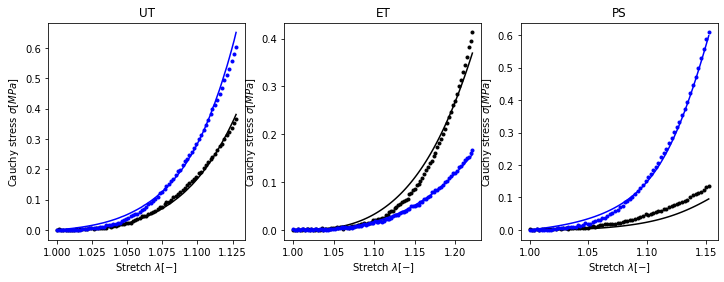

In [19]:
model = NODE_model(*params_a)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [20]:
# save the result with pickle
with open('savednet/NODE_skinparams_all.npy', 'wb') as f:
    pickle.dump(params_a, f)

In [21]:
params_e, key = init_node(key)
opt_init, opt_update, get_params = optimizers.adam(1.e-4) #Original: 1.e-4
opt_state = opt_init(params_e)
mdlnumber = 3
params_e, train_loss, val_loss = train_jp(loss_sig_e, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 3.866552e-03
it 2000, train loss = 2.123881e-03
it 3000, train loss = 1.489856e-03
it 4000, train loss = 1.240581e-03
it 5000, train loss = 1.110982e-03
it 6000, train loss = 1.026573e-03
it 7000, train loss = 9.615113e-04
it 8000, train loss = 9.080712e-04
it 9000, train loss = 8.614685e-04
it 10000, train loss = 7.505773e-04
it 11000, train loss = 6.378290e-04
it 12000, train loss = 6.029696e-04
it 13000, train loss = 4.945617e-04
it 14000, train loss = 2.241861e-04
it 15000, train loss = 1.640636e-04
it 16000, train loss = 8.855907e-05
it 17000, train loss = 5.371500e-05
it 18000, train loss = 3.842663e-05
it 19000, train loss = 3.253895e-05
it 20000, train loss = 3.054207e-05
it 21000, train loss = 2.955184e-05
it 22000, train loss = 2.868952e-05
it 23000, train loss = 2.793848e-05
it 24000, train loss = 2.687021e-05
it 25000, train loss = 2.589453e-05
it 26000, train loss = 2.485161e-05
it 27000, train loss = 2.375213e-05
it 28000, train loss = 2.256407e-05
i

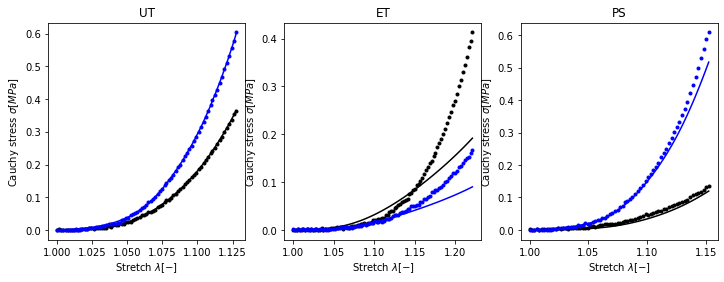

In [22]:
model = NODE_model(*params_e)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [23]:
# save the result with pickle
with open('savednet/NODE_skinparams_equi.npy', 'wb') as f:
    pickle.dump(params_e, f)

In [10]:
key, subkey = random.split(key)
params_sx, key = init_node(key)
opt_init, opt_update, get_params = optimizers.adam(1.e-4) #Original: 1.e-4
opt_state = opt_init(params_sx)
mdlnumber = 3
params_sx, train_loss, val_loss = train_jp(loss_sig_sx, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 2.196718e-03
it 2000, train loss = 9.779371e-04
it 3000, train loss = 6.933232e-04
it 4000, train loss = 5.887125e-04
it 5000, train loss = 5.362039e-04
it 6000, train loss = 5.053138e-04
it 7000, train loss = 4.846905e-04
it 8000, train loss = 4.695591e-04
it 9000, train loss = 4.580078e-04
it 10000, train loss = 4.469363e-04
it 11000, train loss = 4.193136e-04
it 12000, train loss = 3.168298e-04
it 13000, train loss = 1.773505e-04
it 14000, train loss = 9.763907e-05
it 15000, train loss = 7.146729e-05
it 16000, train loss = 6.514228e-05
it 17000, train loss = 5.866302e-05
it 18000, train loss = 5.522286e-05
it 19000, train loss = 4.457169e-05
it 20000, train loss = 4.121462e-05
it 21000, train loss = 3.918743e-05
it 22000, train loss = 3.747506e-05
it 23000, train loss = 3.599335e-05
it 24000, train loss = 3.468244e-05
it 25000, train loss = 3.350286e-05
it 26000, train loss = 3.242624e-05
it 27000, train loss = 3.143352e-05
it 28000, train loss = 3.051343e-05
i

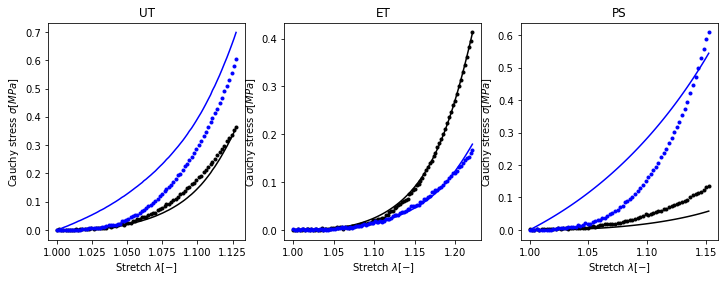

In [67]:
model = NODE_model(*params_sx)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [29]:
# save the result with pickle
with open('savednet/NODE_skinparams_sx.npy', 'wb') as f:
    pickle.dump(params_sx, f)

In [30]:
params_sy, key = init_node(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_sy)
mdlnumber = 3
params_sy, train_loss, val_loss = train_jp(loss_sig_sy, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 4.508261e-03
it 2000, train loss = 2.661221e-03
it 3000, train loss = 2.258302e-03
it 4000, train loss = 2.038190e-03
it 5000, train loss = 1.885863e-03
it 6000, train loss = 1.767206e-03
it 7000, train loss = 1.662647e-03
it 8000, train loss = 1.570001e-03
it 9000, train loss = 1.488508e-03
it 10000, train loss = 1.420944e-03
it 11000, train loss = 1.347334e-03
it 12000, train loss = 1.296545e-03
it 13000, train loss = 1.259921e-03
it 14000, train loss = 1.232227e-03
it 15000, train loss = 1.211837e-03
it 16000, train loss = 1.196304e-03
it 17000, train loss = 1.180017e-03
it 18000, train loss = 9.519158e-05
it 19000, train loss = 8.548582e-05
it 20000, train loss = 7.686461e-05
it 21000, train loss = 6.383353e-05
it 22000, train loss = 4.929725e-05
it 23000, train loss = 4.175638e-05
it 24000, train loss = 3.962811e-05
it 25000, train loss = 3.833666e-05
it 26000, train loss = 3.776298e-05
it 27000, train loss = 3.730551e-05
it 28000, train loss = 3.679333e-05
i

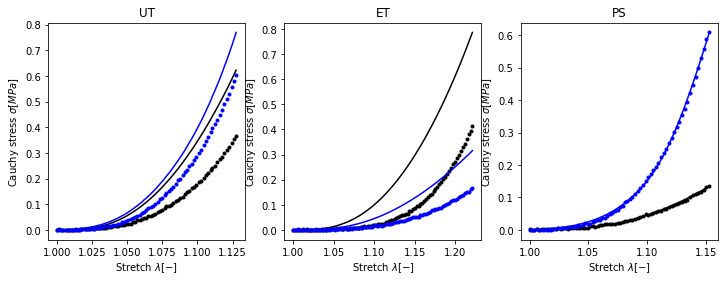

In [31]:
model = NODE_model(*params_sy)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [32]:
# save the result with pickle
with open('savednet/NODE_skinparams_sy.npy', 'wb') as f:
    pickle.dump(params_sy, f)

## Train ICNN

In [33]:
params_icnn_all, key = init_icnn(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_all)
mdlnumber = 2
params_icnn_all, train_loss, val_loss = train_jp(loss_sig_all, mdlnumber, lamb_sigma, opt_state, key, nIter = 100000) #Original 100000

it 1000, train loss = 1.457719e-01
it 2000, train loss = 8.424083e-02
it 3000, train loss = 5.453882e-02
it 4000, train loss = 3.838751e-02
it 5000, train loss = 2.917702e-02
it 6000, train loss = 2.388387e-02
it 7000, train loss = 2.089405e-02
it 8000, train loss = 1.922757e-02
it 9000, train loss = 1.820493e-02
it 10000, train loss = 1.733061e-02
it 11000, train loss = 1.638778e-02
it 12000, train loss = 1.543112e-02
it 13000, train loss = 1.449738e-02
it 14000, train loss = 1.349374e-02
it 15000, train loss = 1.228542e-02
it 16000, train loss = 1.089525e-02
it 17000, train loss = 9.609584e-03
it 18000, train loss = 8.827797e-03
it 19000, train loss = 8.576291e-03
it 20000, train loss = 7.896043e-03
it 21000, train loss = 4.095396e-03
it 22000, train loss = 2.325605e-03
it 23000, train loss = 1.554283e-03
it 24000, train loss = 1.255458e-03
it 25000, train loss = 1.134538e-03
it 26000, train loss = 1.059130e-03
it 27000, train loss = 9.938467e-04
it 28000, train loss = 9.371808e-04
i

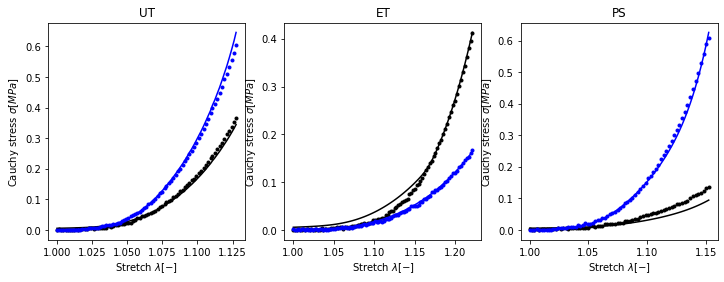

In [34]:
model = ICNN_model(*params_icnn_all,normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [35]:
# save the result with pickle
with open('savednet/ICNN_skinparams_all.npy', 'wb') as f:
    pickle.dump(params_icnn_all, f)

In [36]:
params_icnn_e, key = init_icnn(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_e)
mdlnumber = 2
params_icnn_e, train_loss, val_loss = train_jp(loss_sig_e, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 1.370914e+00
it 2000, train loss = 8.666283e-01
it 3000, train loss = 5.776756e-01
it 4000, train loss = 3.954919e-01
it 5000, train loss = 2.742890e-01
it 6000, train loss = 1.913997e-01
it 7000, train loss = 1.341291e-01
it 8000, train loss = 9.462361e-02
it 9000, train loss = 6.765719e-02
it 10000, train loss = 4.958707e-02
it 11000, train loss = 3.780576e-02
it 12000, train loss = 3.041475e-02
it 13000, train loss = 2.600778e-02
it 14000, train loss = 2.351345e-02
it 15000, train loss = 2.207578e-02
it 16000, train loss = 2.100486e-02
it 17000, train loss = 1.991061e-02
it 18000, train loss = 1.880065e-02
it 19000, train loss = 1.776845e-02
it 20000, train loss = 1.666627e-02
it 21000, train loss = 1.487770e-02
it 22000, train loss = 1.232549e-02
it 23000, train loss = 9.366513e-03
it 24000, train loss = 6.588082e-03
it 25000, train loss = 4.693063e-03
it 26000, train loss = 3.900540e-03
it 27000, train loss = 3.689465e-03
it 28000, train loss = 3.575989e-03
i

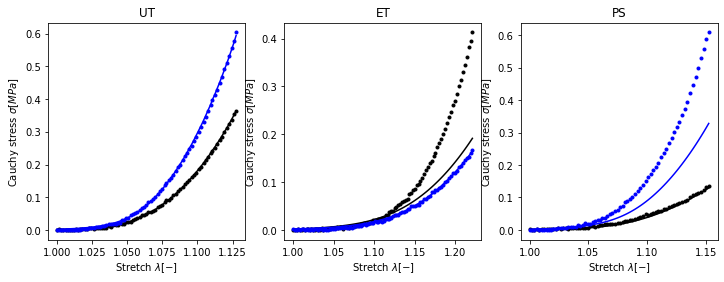

In [37]:
model = ICNN_model(*params_icnn_e,normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [38]:
# save the result with pickle
with open('savednet/ICNN_skinparams_equi.npy', 'wb') as f:
    pickle.dump(params_icnn_e, f)

In [39]:
params_icnn_sx, key = init_icnn(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_sx)
mdlnumber = 2
params_icnn_sx, train_loss, val_loss = train_jp(loss_sig_sx, mdlnumber, lamb_sigma, opt_state, key, nIter = 70000)

it 1000, train loss = 1.861454e-01
it 2000, train loss = 1.063671e-01
it 3000, train loss = 6.649768e-02
it 4000, train loss = 4.393988e-02
it 5000, train loss = 3.034913e-02
it 6000, train loss = 2.188746e-02
it 7000, train loss = 1.654063e-02
it 8000, train loss = 1.315500e-02
it 9000, train loss = 1.102992e-02
it 10000, train loss = 9.722196e-03
it 11000, train loss = 8.933460e-03
it 12000, train loss = 8.435909e-03
it 13000, train loss = 8.042928e-03
it 14000, train loss = 7.647979e-03
it 15000, train loss = 7.258435e-03
it 16000, train loss = 6.908407e-03
it 17000, train loss = 6.575192e-03
it 18000, train loss = 6.128986e-03
it 19000, train loss = 5.392360e-03
it 20000, train loss = 4.326120e-03
it 21000, train loss = 3.025546e-03
it 22000, train loss = 1.746947e-03
it 23000, train loss = 8.208665e-04
it 24000, train loss = 3.770967e-04
it 25000, train loss = 2.486114e-04
it 26000, train loss = 2.087416e-04
it 27000, train loss = 1.791083e-04
it 28000, train loss = 1.529066e-04
i

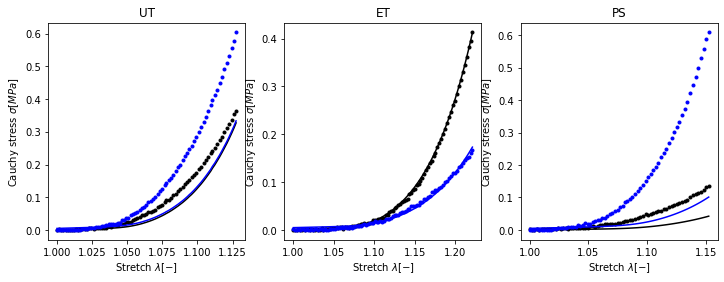

In [40]:
model = ICNN_model(*params_icnn_sx,normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [41]:
# save the result with pickle
with open('savednet/ICNN_skinparams_sx.npy', 'wb') as f:
    pickle.dump(params_icnn_sx, f)

In [42]:
params_icnn_sy, key = init_icnn(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_sy)
mdlnumber = 2
params_icnn_sy, train_loss, val_loss = train_jp(loss_sig_sy, mdlnumber, lamb_sigma, opt_state, key, nIter = 70000)

it 1000, train loss = 6.343101e-02
it 2000, train loss = 4.095341e-02
it 3000, train loss = 3.052966e-02
it 4000, train loss = 2.515685e-02
it 5000, train loss = 2.221694e-02
it 6000, train loss = 2.040313e-02
it 7000, train loss = 1.889953e-02
it 8000, train loss = 1.725817e-02
it 9000, train loss = 1.567737e-02
it 10000, train loss = 1.424560e-02
it 11000, train loss = 1.268117e-02
it 12000, train loss = 1.080543e-02
it 13000, train loss = 8.591771e-03
it 14000, train loss = 6.227956e-03
it 15000, train loss = 4.123851e-03
it 16000, train loss = 2.711519e-03
it 17000, train loss = 2.079773e-03
it 18000, train loss = 1.891933e-03
it 19000, train loss = 1.811452e-03
it 20000, train loss = 1.748496e-03
it 21000, train loss = 1.694296e-03
it 22000, train loss = 1.646686e-03
it 23000, train loss = 1.603774e-03
it 24000, train loss = 1.563368e-03
it 25000, train loss = 1.520215e-03
it 26000, train loss = 1.357615e-03
it 27000, train loss = 8.317189e-04
it 28000, train loss = 4.052858e-04
i

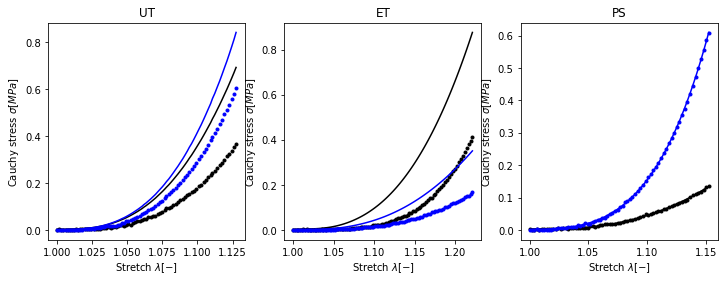

In [43]:
model = ICNN_model(*params_icnn_sy,normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [44]:
# save the result with pickle
with open('savednet/ICNN_skinparams_sy.npy', 'wb') as f:
    pickle.dump(params_icnn_sy, f)

## CANN training

In [45]:
params_cann_all, key = init_cann(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_all)
mdlnumber = 1
params_cann_all, train_loss, val_loss = train_jp(loss_sig_all, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 1.810988e-02
it 2000, train loss = 1.186690e-02
it 3000, train loss = 6.354323e-03
it 4000, train loss = 3.858348e-03
it 5000, train loss = 2.545270e-03
it 6000, train loss = 1.737313e-03
it 7000, train loss = 1.179093e-03
it 8000, train loss = 8.837759e-04
it 9000, train loss = 7.399496e-04
it 10000, train loss = 6.653019e-04
it 11000, train loss = 6.233795e-04
it 12000, train loss = 5.979665e-04
it 13000, train loss = 5.808379e-04
it 14000, train loss = 5.633046e-04
it 15000, train loss = 5.456394e-04
it 16000, train loss = 5.361550e-04
it 17000, train loss = 5.312188e-04
it 18000, train loss = 5.282505e-04
it 19000, train loss = 5.260673e-04
it 20000, train loss = 5.240897e-04
it 21000, train loss = 5.219805e-04
it 22000, train loss = 5.195807e-04
it 23000, train loss = 5.169138e-04
it 24000, train loss = 5.139610e-04
it 25000, train loss = 5.106449e-04
it 26000, train loss = 5.068807e-04
it 27000, train loss = 5.025540e-04
it 28000, train loss = 4.975479e-04
i

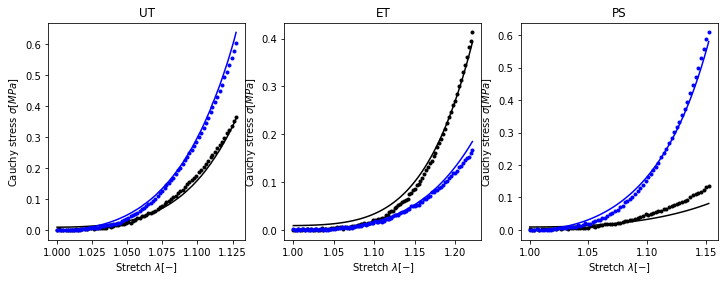

In [46]:
model = CANN_model(*params_cann_all,normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [47]:
with open('savednet/CANN_skinparams_all.npy', 'wb') as f:
    pickle.dump(params_cann_all, f)

In [48]:
params_cann_e, key = init_cann(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_e)
mdlnumber = 1
params_cann_e, train_loss, val_loss = train_jp(loss_sig_e, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 2.840814e-02
it 2000, train loss = 1.585274e-02
it 3000, train loss = 9.252222e-03
it 4000, train loss = 5.300647e-03
it 5000, train loss = 2.794941e-03
it 6000, train loss = 1.346836e-03
it 7000, train loss = 6.600158e-04
it 8000, train loss = 3.649401e-04
it 9000, train loss = 2.231690e-04
it 10000, train loss = 1.455815e-04
it 11000, train loss = 1.012744e-04
it 12000, train loss = 7.563742e-05
it 13000, train loss = 5.990898e-05
it 14000, train loss = 4.747766e-05
it 15000, train loss = 3.668456e-05
it 16000, train loss = 2.834652e-05
it 17000, train loss = 2.142564e-05
it 18000, train loss = 1.546920e-05
it 19000, train loss = 1.268697e-05
it 20000, train loss = 1.145662e-05
it 21000, train loss = 1.057662e-05
it 22000, train loss = 9.912816e-06
it 23000, train loss = 9.411861e-06
it 24000, train loss = 9.030596e-06
it 25000, train loss = 8.742384e-06
it 26000, train loss = 8.530953e-06
it 27000, train loss = 8.381278e-06
it 28000, train loss = 8.278101e-06
i

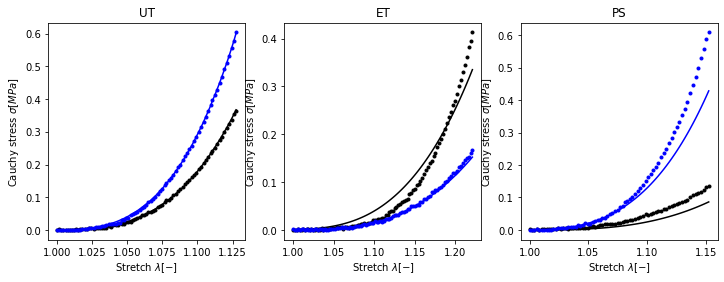

In [49]:
model = CANN_model(*params_cann_e,normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [50]:
with open('savednet/CANN_skinparams_equi.npy', 'wb') as f:
    pickle.dump(params_cann_e, f)

In [51]:
params_cann_sx, key = init_cann(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_sx)
mdlnumber = 1
params_cann_sx, train_loss, val_loss = train_jp(loss_sig_sx, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 7.315090e-03
it 2000, train loss = 4.471834e-03
it 3000, train loss = 2.794213e-03
it 4000, train loss = 1.470058e-03
it 5000, train loss = 8.628950e-04
it 6000, train loss = 6.392795e-04
it 7000, train loss = 5.027744e-04
it 8000, train loss = 3.740712e-04
it 9000, train loss = 2.831732e-04
it 10000, train loss = 2.159063e-04
it 11000, train loss = 1.553732e-04
it 12000, train loss = 1.023896e-04
it 13000, train loss = 6.191227e-05
it 14000, train loss = 3.752364e-05
it 15000, train loss = 2.747932e-05
it 16000, train loss = 2.356637e-05
it 17000, train loss = 1.776850e-05
it 18000, train loss = 1.330088e-05
it 19000, train loss = 1.058190e-05
it 20000, train loss = 1.008416e-05
it 21000, train loss = 9.616941e-06
it 22000, train loss = 9.122779e-06
it 23000, train loss = 8.678204e-06
it 24000, train loss = 8.318762e-06
it 25000, train loss = 8.042637e-06
it 26000, train loss = 7.836039e-06
it 27000, train loss = 7.683817e-06
it 28000, train loss = 7.571693e-06
i

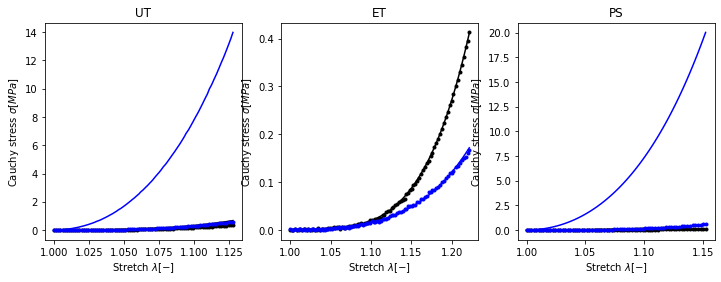

In [52]:
model = CANN_model(*params_cann_sx,normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [53]:
with open('savednet/CANN_skinparams_sx.npy', 'wb') as f:
    pickle.dump(params_cann_sx, f)

In [54]:
params_cann_sy, key = init_cann(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_sy)
mdlnumber = 1
params_cann_sy, train_loss, val_loss = train_jp(loss_sig_sy, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 1.766295e-02
it 2000, train loss = 1.306992e-02
it 3000, train loss = 1.002257e-02
it 4000, train loss = 5.712048e-03
it 5000, train loss = 3.546192e-03
it 6000, train loss = 2.217084e-03
it 7000, train loss = 1.293269e-03
it 8000, train loss = 8.133994e-04
it 9000, train loss = 5.533460e-04
it 10000, train loss = 4.041944e-04
it 11000, train loss = 3.197691e-04
it 12000, train loss = 2.634010e-04
it 13000, train loss = 2.194658e-04
it 14000, train loss = 1.822000e-04
it 15000, train loss = 1.495915e-04
it 16000, train loss = 1.212292e-04
it 17000, train loss = 9.779786e-05
it 18000, train loss = 8.028186e-05
it 19000, train loss = 6.915462e-05
it 20000, train loss = 6.350242e-05
it 21000, train loss = 6.079020e-05
it 22000, train loss = 5.883892e-05
it 23000, train loss = 5.688687e-05
it 24000, train loss = 5.351635e-05
it 25000, train loss = 4.986916e-05
it 26000, train loss = 4.565201e-05
it 27000, train loss = 3.311587e-05
it 28000, train loss = 2.934264e-05
i

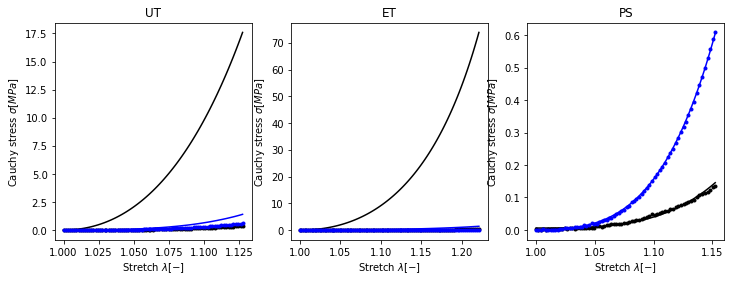

In [55]:
model = CANN_model(*params_cann_sy,normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [56]:
with open('savednet/CANN_skinparams_sy.npy', 'wb') as f:
    pickle.dump(params_cann_sy, f)

# Plot everything

In [57]:
with open('savednet/NODE_skinparams_all.npy', 'rb') as f:
    node_params_a = pickle.load(f)
with open('savednet/NODE_skinparams_equi.npy', 'rb') as f:
    node_params_e = pickle.load(f)
with open('savednet/NODE_skinparams_sx.npy', 'rb') as f:
    node_params_sx = pickle.load(f)
with open('savednet/NODE_skinparams_sy.npy', 'rb') as f:
    node_params_sy = pickle.load(f)

with open('savednet/ICNN_skinparams_all.npy', 'rb') as f:
    icnn_params_a = pickle.load(f)
with open('savednet/ICNN_skinparams_equi.npy', 'rb') as f:
    icnn_params_e = pickle.load(f)
with open('savednet/ICNN_skinparams_sx.npy', 'rb') as f:
    icnn_params_sx = pickle.load(f)
with open('savednet/ICNN_skinparams_sy.npy', 'rb') as f:
    icnn_params_sy = pickle.load(f)

with open('savednet/CANN_skinparams_all.npy', 'rb') as f:
    cann_params_a = pickle.load(f)
with open('savednet/CANN_skinparams_equi.npy', 'rb') as f:
    cann_params_e = pickle.load(f)
with open('savednet/CANN_skinparams_sx.npy', 'rb') as f:
    cann_params_sx = pickle.load(f)
with open('savednet/CANN_skinparams_sy.npy', 'rb') as f:
    cann_params_sy = pickle.load(f)

with open('Data/P12AC1_bsxsy.npy', 'rb') as f:
    lamb, sigma = np.load(f,allow_pickle=True)
lamb_sigma = np.hstack([lamb,sigma])
ind_sx = 81
ind_sy = 182

I1_factor = 5
I2_factor = 7
I4a_factor = 2
I4s_factor = 2
Psi1_factor = 0.5
Psi2_factor = 0.5
Psi4a_factor = 0.5
Psi4s_factor = 0.5
Psi_1_2_factor = 0.5
Psi_1_4a_factor = 0.5
Psi_1_4s_factor = 0.5
Psi_2_4a_factor = 0.5
Psi_2_4s_factor = 0.5
Psi_4a_4s_factor = 0.5
normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,\
                 Psi1_factor,Psi2_factor,Psi4a_factor,Psi4s_factor,\
                 Psi_1_2_factor,Psi_1_4a_factor,Psi_1_4s_factor,\
                 Psi_2_4a_factor,Psi_2_4s_factor, Psi_4a_4s_factor]

params_sx = [cann_params_sx, icnn_params_sx, node_params_sx]
params_e = [cann_params_e, icnn_params_e, node_params_e]
params_sy = [cann_params_sy, icnn_params_sy, node_params_sy]
params_a = [cann_params_a, icnn_params_a, node_params_a]
params_list = [params_sx, params_e, params_sy, params_a]

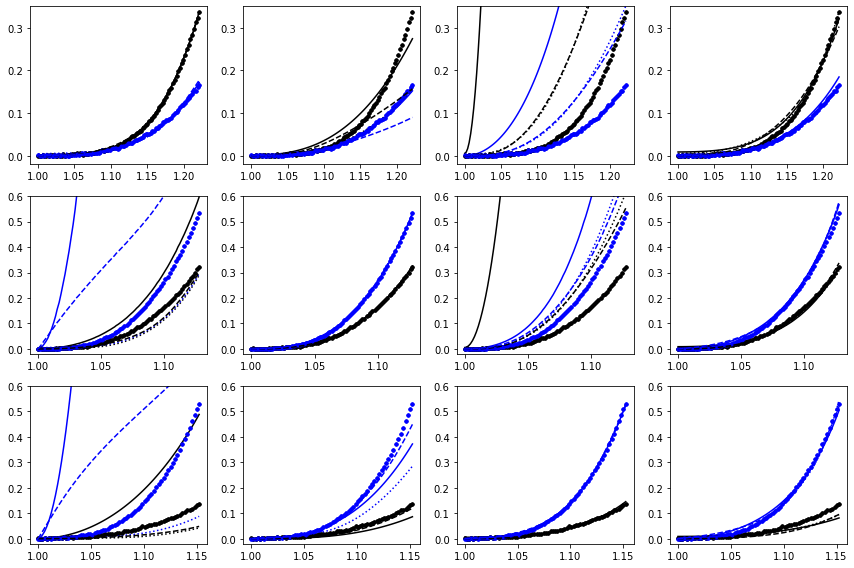

In [58]:
fig, axes = plt.subplots(3,4,figsize=(12,8))
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
panels_list = [['a', 'e', 'i'], ['b', 'f', 'j'], ['c', 'g', 'k'], ['d', 'h', 'l']]

for ax, params, panels in zip(axes.T, params_list, panels_list):
    params_cann, params_icnn, params_node = params

    cann_model = CANN_model(*params_cann, normalization)
    icnn_model = ICNN_model(*params_icnn, normalization)
    node_model = NODE_model(*params_node)

    models = [cann_model, icnn_model, node_model]
    plotstyles = ['-', ':', '--']
    modelnames = ['CANN', 'ICNN', 'NODE']

    for model, modelname, style in zip(models, modelnames, plotstyles):
        indices = [[ind_sx,ind_sy], [0, ind_sx], [ind_sy,lamb.shape[0]]]
        whichlambda = [0,0,1] #because we need to plot strip-y wrt lm_y and the rest wrt lm_x

        sgm_x_pr, sgm_y_pr = eval_Cauchy(lambx, lamby, model, normalization)
        P_x_pr = sgm_x_pr/lambx
        P_y_pr = sgm_y_pr/lamby
        P_x_gt = lamb_sigma[:,2]/lambx
        P_y_gt = lamb_sigma[:,3]/lamby
        ylims = [[-0.020,0.35],[-0.020,0.6],[-0.020,0.6]]
        for axi, (i1,i2), lmid, ylim, panel in zip(ax,indices, whichlambda, ylims, panels):
            lm = lamb_sigma[i1:i2,lmid]
            axi.plot(lm, P_x_gt[i1:i2],'k.',label='$P_x$ Exp.')
            axi.plot(lm, P_y_gt[i1:i2],'b.',label='$P_y$ Exp.')

            axi.plot(lm, P_x_pr[i1:i2],'k'+style, label='$P_x$ '+modelname)
            axi.plot(lm, P_y_pr[i1:i2],'b'+style, label='$P_y$ '+modelname)

            axi.set(ylim=ylim)

            # Save for TikZ
            data = np.array([lm, P_x_gt[i1:i2], P_y_gt[i1:i2]]).T
            columns = ['x', 'P_x_gt', 'P_y_gt']
            df = pd.DataFrame(data, columns = columns)
            df.to_csv('TikZ/fig_skin1_data/data'+'_'+panel+'.csv', index=False, sep=' ')

            data = np.array([lm, P_x_pr[i1:i2], P_y_pr[i1:i2]]).T
            columns = ['x', 'P_x_pr', 'P_y_pr']
            df = pd.DataFrame(data, columns = columns)
            df.to_csv('TikZ/fig_skin1_data/'+modelname+'_'+panel+'.csv', index=False, sep=' ')
# axes[0,0].legend()
fig.tight_layout()
            

# 50 runs

In [10]:
cann_r2 = []
icnn_r2 = []
node_r2 = []
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
for i in range(10):
    print(i)
    mdlnumbers = [1,2,3]
    init_fns = [init_cann, init_icnn, init_node]
    MODELS = [CANN_model, ICNN_model, NODE_model]

    cann_r2i = []
    icnn_r2i = []
    node_r2i = []
    r2lists = [cann_r2i, icnn_r2i, node_r2i]

    for mdlnumber, init_fn, MODEL, r2list in zip(mdlnumbers, init_fns, MODELS, r2lists):
        for loss_fn in ([loss_sig_sx, loss_sig_e, loss_sig_sy, loss_sig_all]):
            key, subkey = random.split(key)
            params, key = init_fn(key)

            opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
            opt_state = opt_init(params)
            params, train_loss, val_loss = train_jp(loss_fn, mdlnumber, lamb_sigma, opt_state, key, nIter = 70000, print_freq=200000)

            #make predictions
            if mdlnumber == 3:
                model = MODEL(*params)
            else:
                model = MODEL(*params, normalization)
            
            indices = [[ind_sx,ind_sy], [0, ind_sx], [ind_sy,lamb.shape[0]]]
            whichlambda = [0,0,1] #because we need to plot strip-y wrt lm_y and the rest wrt lm_x

            sgm_x_pr, sgm_y_pr = eval_Cauchy(lambx, lamby, model, normalization)
            P_x_pr = sgm_x_pr/lambx
            P_y_pr = sgm_y_pr/lamby
            P_x_gt = lamb_sigma[:,2]/lambx
            P_y_gt = lamb_sigma[:,3]/lamby
            for (i1,i2) in indices:
                r2_1 = r2_score(P_x_gt[i1:i2], P_x_pr[i1:i2])
                r2_2 = r2_score(P_y_gt[i1:i2], P_y_pr[i1:i2])
                r2 = 0.5*(r2_1+r2_2)
                r2list.append(r2)
    cann_r2.append(cann_r2i)
    icnn_r2.append(icnn_r2i)
    node_r2.append(node_r2i)

CANN_r2 = np.array(cann_r2)
ICNN_r2 = np.array(icnn_r2)
NODE_r2 = np.array(node_r2)
with open('savednet/CANN_skin_r2_alldata.npy', 'wb') as f:
    pickle.dump(CANN_r2, f)
with open('savednet/ICNN_skin_r2_alldata.npy', 'wb') as f:
    pickle.dump(ICNN_r2, f)
with open('savednet/NODE_skin_r2_alldata.npy', 'wb') as f:
    pickle.dump(NODE_r2, f)

0
1


In [48]:
CANN_r2 = np.clip(CANN_r2, a_min=0.0, a_max=1.0)
ICNN_r2 = np.clip(ICNN_r2, a_min=0.0, a_max=1.0)
NODE_r2 = np.clip(NODE_r2, a_min=0.0, a_max=1.0)

CANN_r2_mean = np.mean(CANN_r2,axis=0)
CANN_r2_stdv = np.std(CANN_r2,axis=0)

ICNN_r2_mean = np.mean(ICNN_r2,axis=0)
ICNN_r2_stdv = np.std(ICNN_r2,axis=0)

NODE_r2_mean = np.mean(NODE_r2,axis=0)
NODE_r2_stdv = np.std(NODE_r2,axis=0)

# Save for TikZ
xs = [0.0, 1.0, 2.0]
r2_means = [CANN_r2_mean, ICNN_r2_mean, NODE_r2_mean]
r2_stdvs = [CANN_r2_stdv, ICNN_r2_stdv, NODE_r2_stdv]
names = ['CANN', 'ICNN', 'NODE']
for name, x, r2_mean, r2_stdv in zip(names, xs, r2_means, r2_stdvs):
    columns = ['x', 'a', 'e', 'i', 'b', 'f', 'j', 'c', 'g', 'k', 'd', 'h', 'l']
    data = np.expand_dims(np.hstack([x,r2_mean]),axis=0)
    df = pd.DataFrame(data, columns=columns)
    df.to_csv('TikZ/fig_skinR2_data/'+name+'_mean.csv', index=False, sep = ' ')

    data1 = np.expand_dims(np.hstack([x,r2_mean-r2_stdv]),axis=0)
    data2 = np.expand_dims(np.hstack([x,r2_mean+r2_stdv]),axis=0)
    data = np.vstack([data1,data2])
    df = pd.DataFrame(data, columns=columns)
    df.to_csv('TikZ/fig_skinR2_data/'+name+'_stdv.csv', index=False, sep = ' ')

CANN_r2_mean = CANN_r2_mean.reshape([4,3]).T
CANN_r2_stdv = CANN_r2_stdv.reshape([4,3]).T
ICNN_r2_mean = ICNN_r2_mean.reshape([4,3]).T
ICNN_r2_stdv = ICNN_r2_stdv.reshape([4,3]).T
NODE_r2_mean = NODE_r2_mean.reshape([4,3]).T
NODE_r2_stdv = NODE_r2_stdv.reshape([4,3]).T

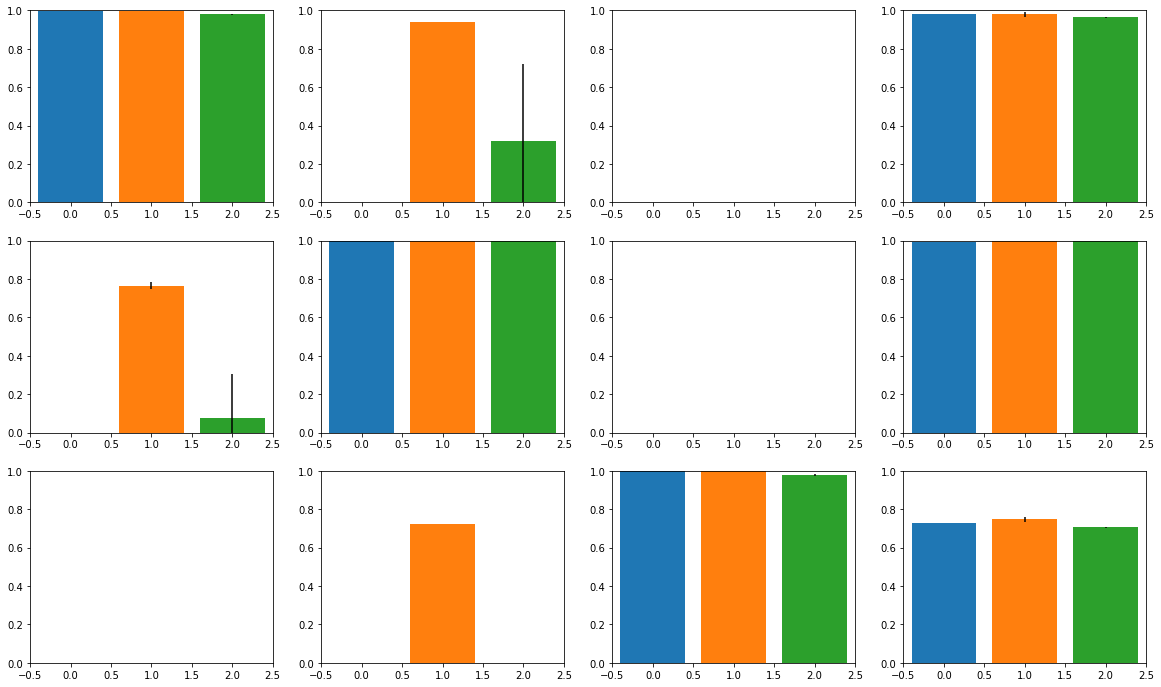

In [47]:
fig, axes = plt.subplots(3,4, figsize=(20,12))

r2_means = [CANN_r2_mean, ICNN_r2_mean, NODE_r2_mean]
r2_stdvs = [CANN_r2_stdv, ICNN_r2_stdv, NODE_r2_stdv]
for x, model_r2_mean, model_r2_stdv in zip(xs, r2_means, r2_stdvs):
    for ax, row_r2_mean, row_r2_stdv in zip(axes, model_r2_mean, model_r2_stdv):
        for axi, r2_mean, r2_stdv in zip(ax, row_r2_mean, row_r2_stdv):
            axi.bar(x, r2_mean)
            axi.errorbar(x, r2_mean, r2_stdv, color='black')
            axi.set(xlim=[-0.5,2.5], ylim=[0,1])

fig.savefig('Figures/fig_skin_R2.jpg')